In [1]:
import os
os.chdir('C:\\Users\\Administrator\\Downloads\\ML Lab')

In [2]:

from timeseires.utils.to_split import to_split
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Dense, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU

In [3]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab7'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [7]:
model = None
start_epoch = 0
time_steps=24
num_features=21

In [8]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [9]:
import os
path_dataset ='C:\\Users\\Administrator\\Downloads\\ML Lab\\AEP_hourly\\processed'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

C:\Users\Administrator\anaconda3\envs\Time1\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [12]:
train_set

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00, ...,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00, ...,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.26232372e-01,  1.00000000e+00,  0.00000000e+00, ...,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       ...,
       [ 3.05503557e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  3.93590277e-01, -9.19285970e-01],
       [ 3.08873081e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  3.93590277e-01, -9.19285970e-01],
       [ 2.94583801e-01,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  3.93590277e-01, -9.19285970e-01]])

In [22]:
train_X , train_y = to_split(train_set, time_steps=4, target_col=0, target_len=1)

In [23]:
train_X[0]

array([[ 1.69100212e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         2.58819045e-01,  9.65925826e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.41395233e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e-01,
         5.00000000e-01,  8.66025404e-01,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         6.12323400e-17, -9.99768502e-01,  2.15160974e-02],
       [ 1.26232372e-01,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.66025404e-01,
         5.00000000e-01, -8.66025404e-01, -5.00000000e

In [24]:
train_y[0]

array([0.12554599])

In [13]:
start = time.time()
train_X , train_y = to_split(train_set, time_steps=time_steps, target_col=0, target_len=1)
validation_X, validation_y = to_split(validation_set, time_steps=time_steps, target_col=0, target_len=1)
test_X, test_y = to_split(test_set, time_steps=time_steps, target_col=0, target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.6282544136047363 sec


In [11]:
epochs = 40
verbose = 1 #0
batch_size = 512
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   #pa batch 16 mape 7.72%
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Train on 32638 samples, validate on 9274 samples
Epoch 1/40
31232/32638 [===========================>..] - ETA: 0s - loss: 0.0941 - mae: 0.0941 - mape: 10115.1055
Epoch 00001: val_loss improved from inf to 0.06557, saving model to C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E1-cp-0001-loss0.07.h5
32638/32638 [==============================] - 5s 159us/sample - loss: 0.0923 - mae: 0.0923 - mape: 9679.9150 - val_loss: 0.0656 - val_mae: 0.0656 - val_mape: 10.8854
Epoch 2/40
32256/32638 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.0358 - mape: 10104.8818
Epoch 00002: val_loss improved from 0.06557 to 0.03586, saving model to C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E1-cp-0002-loss0.04.h5
32638/32638 [==============================] - 2s 59us/sample - loss: 0.0359 - mae: 0.0359 - mape: 9986.7168 - val_loss: 0.0359 - val_mae: 0.0359 - val_mape: 6.6421
Epoch 3/40
31232/32638 [===============

# Experiemnt 2

In [15]:
checkpoints='C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Checkpoints\\Paper1\\1_googleNet1D\\exp 3_a\\E2_cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Checkpoints\\Paper1\\1_googleNet1D\\exp 3_a\\E1-cp-0038-loss0.02.h5'
start_epoch=39

In [16]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [17]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = build_model()
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer='adam', metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-3)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E1-cp-0038-loss0.02.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 0.0010000000474974513


In [18]:
epochs = 20
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   #pa batch 16 mape 7.72%
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Train on 32638 samples, validate on 9274 samples
Epoch 1/20
30720/32638 [===========================>..] - ETA: 0s - loss: 0.0155 - mae: 0.0155 - mape: 9915.5977 
Epoch 00001: val_loss improved from inf to 0.02338, saving model to C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E2_cp-0001-loss0.02.h5
32638/32638 [==============================] - 3s 83us/sample - loss: 0.0155 - mae: 0.0155 - mape: 9333.1104 - val_loss: 0.0234 - val_mae: 0.0234 - val_mape: 4.1899
Epoch 2/20
30720/32638 [===========================>..] - ETA: 0s - loss: 0.0153 - mae: 0.0153 - mape: 9737.4648 
Epoch 00002: val_loss improved from 0.02338 to 0.02300, saving model to C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E2_cp-0002-loss0.02.h5
32638/32638 [==============================] - 2s 49us/sample - loss: 0.0153 - mae: 0.0153 - mape: 9165.4072 - val_loss: 0.0230 - val_mae: 0.0230 - val_mape: 4.1990
Epoch 3/20
31744/32638 [=================

In [25]:
import pickle
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 385.32
Median Absolute Error (MedAE): 318.81
Mean Squared Error (MSE): 249919.88
Root Mean Squared Error (RMSE): 499.92
Mean Absolute Percentage Error (MAPE): 3.86 %
Median Absolute Percentage Error (MDAPE): 3.11 %


y_test_unscaled.shape=  (4600, 1)
y_pred.shape=  (4600, 1)


# Experemnet 3

In [27]:
checkpoints='C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Checkpoints\\Paper1\\1_googleNet1D\\exp 3_a\\E3_cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model='C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Checkpoints\\Paper1\\1_googleNet1D\\exp 3_a\\E2_cp-0020-loss0.02.h5'
start_epoch=20

In [28]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [29]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = build_model()
    opt = Adam(1e-2)
    model.compile(loss= 'mae', optimizer='adam', metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E2_cp-0020-loss0.02.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [30]:
epochs = 20
verbose = 1 #0
batch_size = 1024
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   #pa batch 16 mape 7.72%
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)


Train on 32638 samples, validate on 9274 samples
Epoch 1/20
31744/32638 [============================>.] - ETA: 0s - loss: 0.0137 - mae: 0.0137 - mape: 9547.2959 
Epoch 00001: val_loss improved from inf to 0.02179, saving model to C:\Users\arif\OneDrive\Journal Paper\Code\Checkpoints\Paper1\1_googleNet1D\exp 3_a\E3_cp-0001-loss0.02.h5
32638/32638 [==============================] - 3s 80us/sample - loss: 0.0137 - mae: 0.0137 - mape: 9285.8516 - val_loss: 0.0218 - val_mae: 0.0218 - val_mape: 3.9185
Epoch 2/20
31744/32638 [============================>.] - ETA: 0s - loss: 0.0135 - mae: 0.0135 - mape: 9480.8213 
Epoch 00002: val_loss did not improve from 0.02179
32638/32638 [==============================] - 2s 53us/sample - loss: 0.0134 - mae: 0.0134 - mape: 9221.1992 - val_loss: 0.0218 - val_mae: 0.0218 - val_mape: 3.9169
Epoch 3/20
30720/32638 [===========================>..] - ETA: 0s - loss: 0.0134 - mae: 0.0134 - mape: 9918.7188
Epoch 00003: val_loss improved from 0.02179 to 0.02179,

In [31]:
import pickle
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))
y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 369.48
Median Absolute Error (MedAE): 289.43
Mean Squared Error (MSE): 236624.74
Root Mean Squared Error (RMSE): 486.44
Mean Absolute Percentage Error (MAPE): 3.66 %
Median Absolute Percentage Error (MDAPE): 2.88 %


y_test_unscaled.shape=  (4600, 1)
y_pred.shape=  (4600, 1)


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import time
import pickle
import pydot
import tensorflow 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Concatenate,Flatten,MaxPooling1D,AveragePooling1D,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,mean_squared_error

In [9]:
def to_split(dataset, time_steps,target_col,target_len):
    '''
    \nto_split(dataset, time_steps,target_col,target_len)\n
    dataset=nd.array
    time_steps= look back the prvous data points like 24hrs, 168 hours etc 
    target_col= index of the column to which you want to pridect
    target_len= how many point do you want to predict
    \n\nExample:
    to call this function
    look_back = 14*24
    train_X,train_y=to_split(train_set, time_steps= look_back,target_col=0,target_len=1)
    validation_X,validation_y=to_split(validation_set, time_steps=look_back,target_col=0,target_len=1)
    test_X,test_y=to_split(test_set,time_steps=look_back,target_col=0,target_len=1)
    '''
    X,y = list(), list()
    for i in range(len(dataset)):
        end_of_x = i + time_steps
        if end_of_x > len(dataset)-1:
            break
        seq_x = dataset[i:end_of_x, :dataset.shape[1]]# df my dff ta convert ko
        X.append(seq_x)
        another_end=end_of_x
        target_list = list()
        for i in range(target_len):
            target_list.append(i+1)
        target_len
        for x in target_list:
            another_end=end_of_x+x
            seq_y=dataset[end_of_x:another_end, target_col]
            if another_end==end_of_x+target_len:    
                y.append(seq_y)
    return np.array(X), np.array(y)

In [10]:
path_tr = 'C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\8_train.csv'
df_tr = pd.read_csv(path_tr, index_col=0)

In [11]:
#train_set = df_tr.iloc[:,[1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]].values #dataset=np.array(df) dwara use koli sho
train_set = df_tr.iloc[:].values #dataset=np.array(df) dwara use koli sho

In [12]:
path_v = 'C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\8_validation.csv'
df_v = pd.read_csv(path_v, index_col=0)

In [13]:
#validation_set = df_v.iloc[:,[1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]].values #dataset=np.array(df) dwara use koli sho
validation_set = df_v.iloc[:].values #dataset=np.array(df) dwara use koli sho

In [14]:
path_te = 'C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\8_test.csv'
df_te = pd.read_csv(path_te, index_col=0)

In [15]:
#test_set = df_te.iloc[:,[1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]].values #dataset=np.array(df) dwara use koli sho
test_set = df_te.iloc[:].values #dataset=np.array(df) dwara use koli sho

In [16]:
start = time.time()
train_X , train_y = to_split(train_set, time_steps=168, target_col=0, target_len=1)
validation_X, validation_y = to_split(validation_set, time_steps=168, target_col=0, target_len=1)
test_X, test_y = to_split(test_set, time_steps=168, target_col=0, target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.3626377582550049 sec


In [27]:
# import the necessary packages
import tensorflow
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2

In [37]:
class PC:
    @staticmethod
    def conv_module(x, num_filter, kr, stride ,padding="same", reg=0.0005, name=None):
        # initialize the CONV, BN, and RELU layer names
        (convName, bnName, actName) = (None, None, None)
        
        # if a layer name was supplied, prepend it
        if name is not None:
            convName = name + "_conv"
            bnName = name + "_bn"
            actName = name + "_act"
        # define a CONV => BN => RELU pattern
        x = Conv1D(num_filter, kr, strides=stride, padding=padding, kernel_regularizer=l2(reg),name=convName)(x)
        x = BatchNormalization(axis=-1, name=bnName)(x)
        x = Activation("relu", name=actName)(x)
        
        # return the block
        return x
    
    @staticmethod
    def inception_module(x, num1x1, num3x3Reduce, num3x3,num5x5Reduce, num5x5, stage, reg=0.0005):
        # define the first branch of the Inception module which
        # consists of 1x1 convolutions
        first = PC.conv_module(x, num1x1, 1, 1, reg=reg, name=stage + "_first")
        
        # define the second branch of the Inception module which
        # consists of 1x1 and 3x3 convolutions
        second = PC.conv_module(x, num3x3Reduce, 1, 1,  reg=reg, name=stage + "_second1")
        second = PC.conv_module(second, num3x3, 3, 1, reg=reg, name=stage + "_second2")
        
        # define the third branch of the Inception module which
        # are our 1x1 and 5x5 convolutions
        third = PC.conv_module(x, num5x5Reduce, 1, 1,  reg=reg, name=stage + "_third1")
        third = PC.conv_module(third, num5x5, 5, 1,  reg=reg, name=stage + "_third2")
        
        # concatenate across the channel dimension
        x = concatenate([first, second, third], axis=-1 ,name=stage + "_mixed")
        
        # return the block
        return x
    @staticmethod
    def build(time_steps, num_features, reg=0.0005):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        # define the model input and first CONV module
        inputs = Input(shape=(time_steps, num_features))
        x = PC.conv_module(inputs, 128, 5, 1)
        x = PC.inception_module(x, 32, 32, 64, 8, 32, "2a")
        x = PC.inception_module(x, 64, 64, 128, 16, 64, "3a")
        x = Flatten()(x)
        x = Dense(1)(x)
        # create the model
        model = Model(inputs, x, name="PC")
        
        # return the constructed network architecture
        return model

In [38]:
pc =  PC.build(time_steps=168, num_features=23, reg=0.0005)

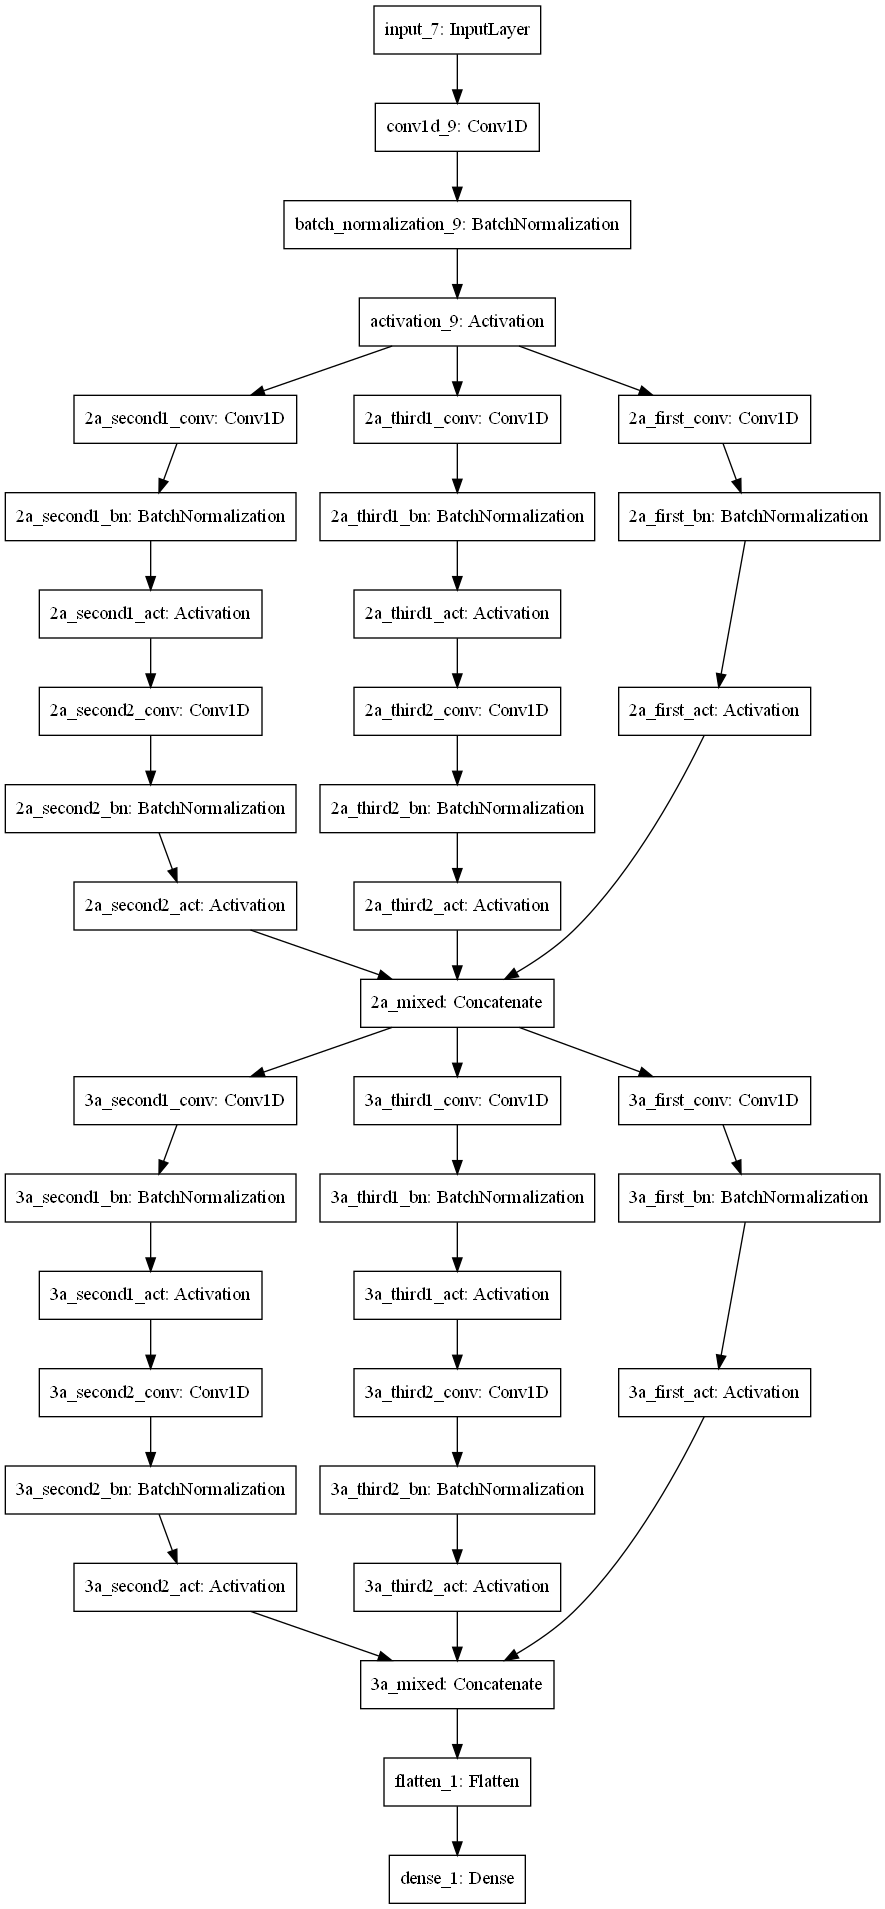

In [39]:
tensorflow .keras.utils.plot_model(pc )

In [26]:
pc.summary()

Model: "PC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 168, 23)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 168, 16)      1120        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 168, 16)      64          conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 168, 16)      0           batch_normalization[0][0]        
_________________________________________________________________________________________________

In [40]:
epochs  = 2
verbose = 1 #0
pc.compile(loss = 'mse', optimizer =  'adam')
History = pc.fit(train_X,
                        train_y,
                        batch_size      = 1024,  
                        epochs          = epochs, 
                        validation_data = (validation_X,validation_y),
                        verbose         = verbose)

Epoch 1/2
32/32 [==============================] - 80s 3s/step - loss: 33.1726 - val_loss: 0.8199
Epoch 2/2
32/32 [==============================] - 80s 3s/step - loss: 1.1338 - val_loss: 0.4562


Mean Absolute Error (MAE): 5238.05
Median Absolute Error (MedAE): 5404.95
Mean Squared Error (MSE): 31445798.41
Root Mean Squared Error (RMSE): 5607.66
Mean Absolute Percentage Error (MAPE): 49.44 %
Median Absolute Percentage Error (MDAPE): 51.27 %


y_test_unscaled.shape=  (4504, 1)
y_pred.shape=  (4504, 1)


In [14]:
dropout      = 0.3
output_shape = 1
time_steps   = 168
num_features = 23
kernal_size  = 3
input_data   = Input(shape=(time_steps, num_features))

       
a = Conv1D(16, kernal_size)(input_data)
a = Conv1D(32, kernal_size, activation  = 'relu')(a)
a = MaxPooling1D(2)(a)
   
a = Dropout(0.3)(a)

a = Conv1D(64, kernal_size, activation  = 'relu')(a)
a = Conv1D(128, kernal_size, activation = 'relu')(a)
a = MaxPooling1D(2)(a)
  
a = Dropout(0.3)(a)

a = Conv1D(256, kernal_size, activation = 'relu')(a)
a = Conv1D(512, kernal_size, activation = 'relu')(a)
a = MaxPooling1D(2)(a)

a = Flatten()(a)
a = Dropout(0.3)(a)
a = Dense(10, activation ='relu')(a)
        
output_data = Dense(1)(a)
        
model = Model(input_data, output_data)
model.compile(loss = 'mse', optimizer =  'adam')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 23)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 166, 16)           1120      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 164, 32)           1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 82, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 82, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 80, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 78, 128)          

In [15]:
epochs  = 2
verbose = 1 #0
History = model.fit(train_X,
                        train_y,
                        batch_size      = 1024,  
                        epochs          = epochs, 
                        validation_data = (validation_X,validation_y),
                        verbose         = verbose)

Epoch 1/2
32/32 [==============================] - 38s 1s/step - loss: 0.1348 - val_loss: 0.0915
Epoch 2/2
32/32 [==============================] - 37s 1s/step - loss: 0.0075 - val_loss: 0.0939


In [16]:
scaler = pickle.load(open("C:\\Users\\arif\\OneDrive\\Journal Paper\\Code\\Irshad\\Dataset\\scaler.pkl", 'rb'))

In [17]:
y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))

In [18]:
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

Mean Absolute Error (MAE): 3444.96
Median Absolute Error (MedAE): 3550.58
Mean Squared Error (MSE): 14252245.21
Root Mean Squared Error (RMSE): 3775.21
Mean Absolute Percentage Error (MAPE): 31.94 %
Median Absolute Percentage Error (MDAPE): 33.12 %


y_test_unscaled.shape=  (4504, 1)
y_pred.shape=  (4504, 1)


In [21]:
evaluation = {"Evaluation Metrices":["RMSE","MAE","MSE", "MAPE%"],
              "Value":[mean_squared_error(y_test_unscaled, y_pred, squared=True), 
                       mean_squared_error(y_test_unscaled, y_pred, squared=False),
                       mean_absolute_error(y_test_unscaled, y_pred),
                       mean_absolute_percentage_error(y_test_unscaled, y_pred)*100],}
evaluation = pd.DataFrame(evaluation)
evaluation.style

,Evaluation Metrices,Value
0,RMSE,14252245.211629
1,MAE,3775.214591
2,MSE,3444.962702
3,MAPE%,31.937507


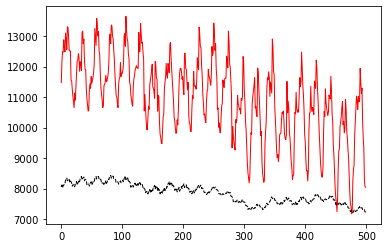

In [22]:
plt.plot(y_test_unscaled[0:500], color = "red",   linewidth = 1, label = 'Actual')
plt.plot(y_pred[0:500],'--',     color = "black", linewidth = 1, label = 'Predicted')
#plt.savefig('C:\\Users\\arif\\OneDrive\\Coference_UET_Lahore\\Graph\\1_Exp1_3block.png', format='png', dpi=1080)

In [11]:
dropout=0.2
CNN_model_1 = Sequential(name='Sequential_API')
CNN_model_1.add(Conv1D(filters=20, kernel_size=3, activation='relu',input_shape=(train_X.shape[1],train_X.shape[2])))
CNN_model_1.add(Activation("elu"))
CNN_model_1.add(Dropout(dropout))
CNN_model_1.add(Flatten()) 
CNN_model_1.compile(loss= 'mae', optimizer='adam', metrics=["mae", "mape"])
CNN_model_1.summary()
tensorflow .keras.utils.plot_model(CNN_model_1 )#, show_layer_names=True, to_file=img_file,, show_shapes=True)

Model: "Sequential_API"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 166, 20)           1040      
_________________________________________________________________
activation (Activation)      (None, 166, 20)           0         
_________________________________________________________________
dropout (Dropout)            (None, 166, 20)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3320)              0         
Total params: 1,040
Trainable params: 1,040
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
epochs  = 20
verbose = 1 
History = CNN_model_1.fit(train_X,train_y,
                          batch_size= 1024,   
                          epochs = epochs, 
                          validation_data = (validation_X,validation_y),
                          verbose = verbose)

Epoch 1/20
32/32 [==============================] - 3s 102ms/step - loss: 0.4219 - mae: 0.4219 - mape: 8332.5449 - val_loss: 0.3151 - val_mae: 0.3151 - val_mape: 7925.1973
Epoch 2/20
32/32 [==============================] - 3s 94ms/step - loss: 0.3310 - mae: 0.3310 - mape: 7918.0972 - val_loss: 0.2148 - val_mae: 0.2148 - val_mape: 8840.9141
Epoch 3/20
32/32 [==============================] - 3s 94ms/step - loss: 0.2459 - mae: 0.2459 - mape: 8703.9668 - val_loss: 0.1518 - val_mae: 0.1518 - val_mape: 8672.4600
Epoch 4/20
32/32 [==============================] - 3s 92ms/step - loss: 0.1956 - mae: 0.1956 - mape: 8506.2217 - val_loss: 0.1288 - val_mae: 0.1288 - val_mape: 8255.0000
Epoch 5/20
32/32 [==============================] - 3s 95ms/step - loss: 0.1724 - mae: 0.1724 - mape: 8238.5088 - val_loss: 0.1194 - val_mae: 0.1194 - val_mape: 8002.7837
Epoch 6/20
32/32 [==============================] - 3s 92ms/step - loss: 0.1645 - mae: 0.1645 - mape: 7972.2939 - val_loss: 0.1172 - val_mae: 0.

In [31]:
# https://github.com/flo7up/relataly-public-python-tutorials/blob/master/009%20Time%20Series%20Forecasting%20-%20Measuring%20Model%20Performance.ipynb

# Get the predicted values
y_pred_scaled = CNN_model_1.predict(test_X)
y_pred = scaler.inverse_transform(y_pred_scaled)[0]
y_test_unscaled = scaler.inverse_transform(test_y.reshape(-1, 1))
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled))
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

Mean Absolute Error (MAE): 5266.89
Median Absolute Error (MedAE): 5009.31
Mean Squared Error (MSE): 39149245.57
Root Mean Squared Error (RMSE): 6256.94
Mean Absolute Percentage Error (MAPE): 37.07 %
Median Absolute Percentage Error (MDAPE): 40.06 %


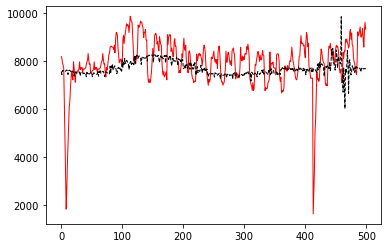

In [33]:
plt.plot(y_test_unscaled[0:500], color="red", linewidth=1,label='Actual');
plt.plot(y_pred[0:500],'--', color="black", linewidth=1,label='Predicted');

In [16]:
df.shape

(32710, 24)

In [18]:
df[:,['System_load']]

TypeError: '(slice(None, None, None), ['System_load'])' is an invalid key

In [13]:
df

,Unnamed: 0,System_load,Year1,Year2,Year3,Year4,Year5,Year6,Month_of_year1,Month_of_year2,...,holiday1,holiday2,winter_peak1,winter_peak2,Spring_Peak1,Spring_Peak,Summer_Peak1,Summer_Peak2,Autumn_peak1,Autumn_peak
0,0,0.318572,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.5,8.660254e-01,1.224647e-16,-1.0,0.000000,1.000000e+00
1,1,0.309504,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.5,8.660254e-01,1.224647e-16,-1.0,0.258819,9.659258e-01
2,2,0.304467,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.5,8.660254e-01,1.224647e-16,-1.0,0.500000,8.660254e-01
3,3,0.303075,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.5,8.660254e-01,1.224647e-16,-1.0,0.707107,7.071068e-01
4,4,0.310512,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.5,8.660254e-01,1.224647e-16,-1.0,0.866025,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32705,32705,0.664684,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,-1.0,-1.836970e-16,0.000000e+00,1.0,-0.965926,-2.588190e-01
32706,32706,0.727199,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,-1.0,-1.836970e-16,0.000000e+00,1.0,-1.000000,-1.836970e-16
32707,32707,0.722593,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,-1.0,-1.836970e-16,0.000000e+00,1.0,-0.965926,2.588190e-01
32708,32708,0.706136,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,-1.0,-1.836970e-16,0.000000e+00,1.0,-0.866025,5.000000e-01
